In [1]:
# this notebook will use NYC 140 years of daily observed_state of "PRCP", "SNOW", "SNWD", "TMAX", "TMIN" to predict "PRCP"
# Gussian processe will be used to model the residual and use this as uncertainty quantification model
# gussian processes will be used as regression to model the daya


In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from typing import Any, Tuple
from matplotlib.patches import Ellipse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# observed_state preprocessing 


# Load the dataset
file_path = 'NYC_Central_Park_weather_1912_onwards.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Convert DATE column to datetime and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)


# Resample target variable (precipitation) and exogenous variables to monthly
precipitation = data['PRCP']  # Target variable
max_temp = data['TMAX']      # Maximum temperature
min_temp = data['TMIN']     # Minimum temperature
snowfall = data['SNOW']      # Snowfall
snowdepth = data['SNWD']      # Snowfall

# Remove missing values
precipitation = precipitation.dropna()
max_temp = max_temp.dropna()
min_temp = min_temp.dropna()
snowfall = snowfall.dropna()
snowfall = snowdepth.dropna()
# Align indices of exogenous variables
exog = pd.concat([max_temp, min_temp, snowfall,snowdepth], axis=1).dropna()
exog.columns = ['MaxTemp', 'MinTemp', 'Snowfall','snowdepth']
precipitation = precipitation.loc[exog.index]  # Align target with exog


In [5]:
# Split into training (75%) and testing (25%) sets
split_index = int(len(precipitation) * 0.95)
train_precip = precipitation.iloc[:split_index]
test_precip = precipitation.iloc[split_index:]
train_exog = exog.iloc[:split_index]
test_exog = exog.iloc[split_index:]

# Log transform target variable to stabilize variance
train_precip_log = (train_precip)
train_precip_log.index = train_precip_log.index.to_period('D')
train_exog.index = train_exog.index.to_period('D')

ADF Statistic: -63.35189230603094
p-value: 0.0
All good!


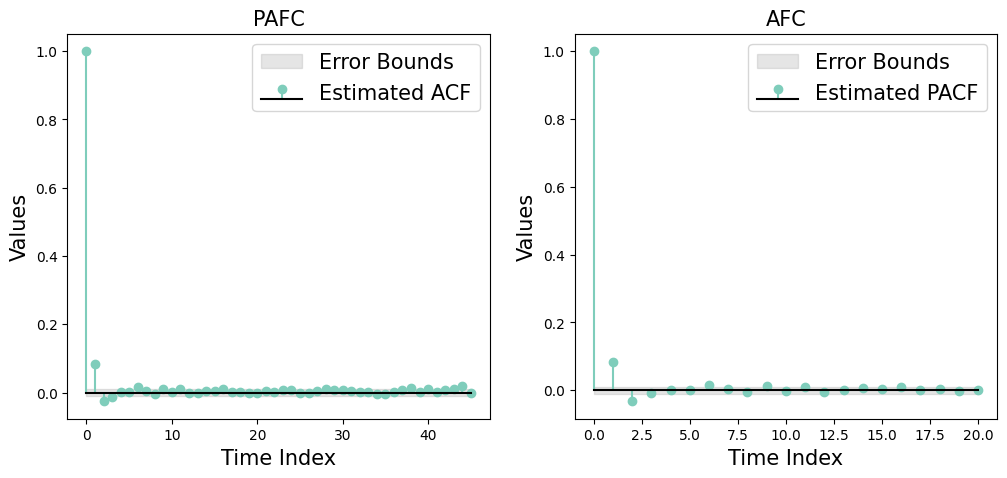

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import arma_acovf
from statsmodels.tsa.stattools import adfuller

# TODO: Plot the ACF and PACF along with the expected error for the estimators.
n_lags = 20
acf_estimate = acf(train_precip_log,n_lags) # TODO
pacf_estimate = pacf(train_precip_log, n_lags) # TODO
acf_error_estimate = 2/np.sqrt(len(train_precip_log))# TODO
pacf_error_estimate = 2/np.sqrt(len(train_precip_log))# TODO
# Check for stationarity
adf_test = adfuller(train_precip_log)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] > 0.05:
    print("The data is not stationary. Differencing may be needed.")
else:
    print("All good!")


    

# TODO: Do the plotting here. See the previous labs for examples.
fontsize = 15                   
colors = ['#7fcdbb', '#2c7fb8']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
ax1.stem(acf_estimate, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated ACF')
ax1.fill_between(range(len(acf_estimate)), -acf_error_estimate, acf_error_estimate, color='gray', alpha=0.2, label="Error Bounds")
ax1.set_title('PAFC', fontsize=fontsize)
ax1.set_xlabel('Time Index', fontsize=fontsize)
ax1.set_ylabel('Values', fontsize=fontsize)
ax1.legend(fontsize=fontsize)


##########################################
ax2.stem(pacf_estimate, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated PACF')
ax2.fill_between(range(len(pacf_estimate)), -acf_error_estimate, acf_error_estimate, color='gray', alpha=0.2, label="Error Bounds")
ax2.set_title('AFC', fontsize=fontsize)
ax2.set_xlabel('Time Index', fontsize=fontsize)
ax2.set_ylabel('Values', fontsize=fontsize)
ax2.legend(fontsize=fontsize)



In [7]:
# import itertools
# import warnings
# warnings.filterwarnings("ignore")

# p = d = q = range(0, 3)
# P = D = Q = range(0, 2)
# s = 12  # Seasonal period for monthly data

# param_combinations = list(itertools.product(p, d, q, P, D, Q))
# best_aic = float("inf")
# best_params = None

# for params in param_combinations:
#     try:
#         model = SARIMAX(train_precip_log,
#                         exog=train_exog,
#                         order=(params[0], params[1], params[2]),
#                         seasonal_order=(params[3], params[4], params[5], s),
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         results = model.fit(disp=False)
#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_params = params
#     except:
#         continue

# print("Best Parameters:", best_params)


In [ ]:
model = SARIMAX(train_precip_log,
                exog=train_exog,
                order=(2, 1, 1),  # Increase AR terms
                seasonal_order=(1, 1, 0, 365),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit model using an alternative optimization algorithm
results = model.fit(disp=False, method='powell')

# Display model summary
print(results.summary())
# Plot diagnostics to evaluate residuals
results.plot_diagnostics(figsize=(12, 8))
plt.show()

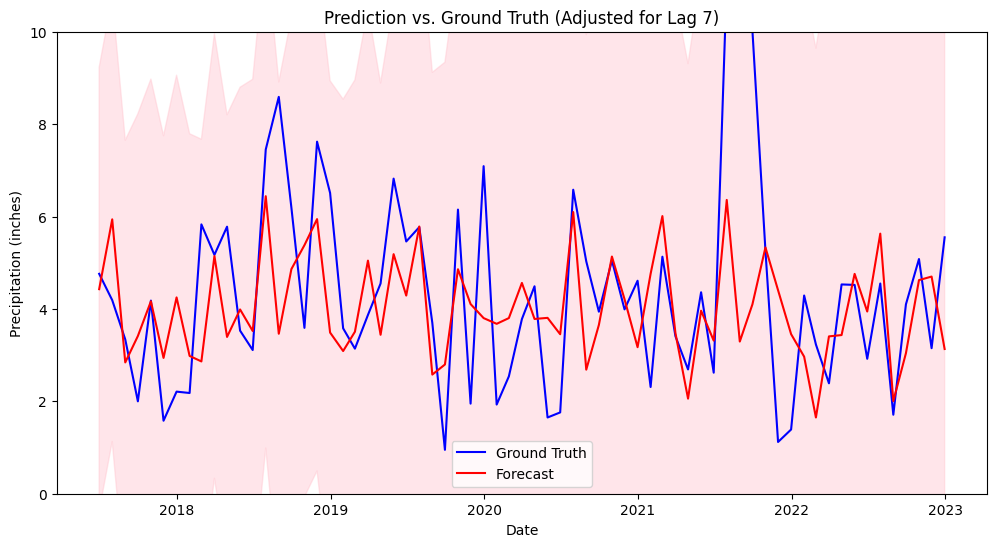

In [ ]:

# Forecasting
forecast = results.get_forecast(steps=len(test_precip.to_period('D')), exog=test_exog.to_period('M'))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Back-transform predictions if log-transformed
# forecast_mean_exp = np.exp(forecast_mean) - 1
# forecast_lower_exp = np.exp(forecast_ci.iloc[:, 0]) - 1
# forecast_upper_exp = np.exp(forecast_ci.iloc[:, 1]) - 1
forecast_mean_exp = (forecast_mean) 
forecast_lower_exp = (forecast_ci.iloc[:, 0]) 
forecast_upper_exp = (forecast_ci.iloc[:, 1]) 


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_precip, label="Ground Truth", color="blue")
plt.plot(forecast_mean_exp, label="Forecast", color="red")
plt.fill_between(forecast_mean_exp.index, forecast_lower_exp, forecast_upper_exp, color='pink', alpha=0.4)
plt.title("Prediction vs. Ground Truth (Adjusted for Lag 7)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend()
plt.ylim(0,10)
plt.show()

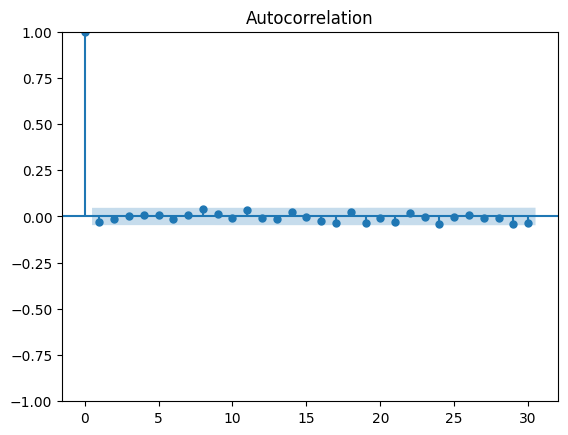

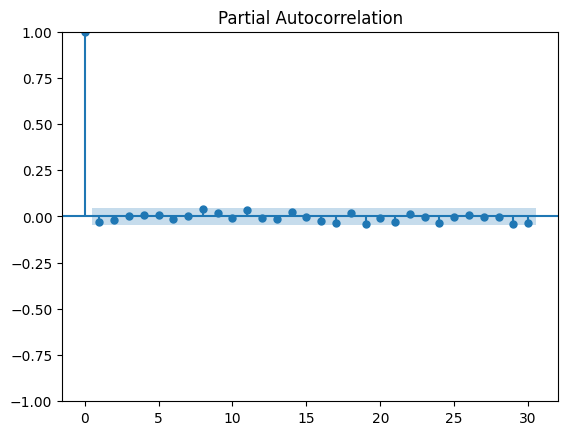

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals = results.resid
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()

In [33]:
# Random Forest to model residuals
from sklearn.ensemble import RandomForestRegressor

residuals = results.resid
rf = RandomForestRegressor()
rf.fit(train_exog, residuals)

# Predict residuals for the test set
residuals_pred = rf.predict(test_exog)

# Adjust SARIMAX predictions with RF residual corrections
hybrid_forecast = forecast_mean + residuals_pred


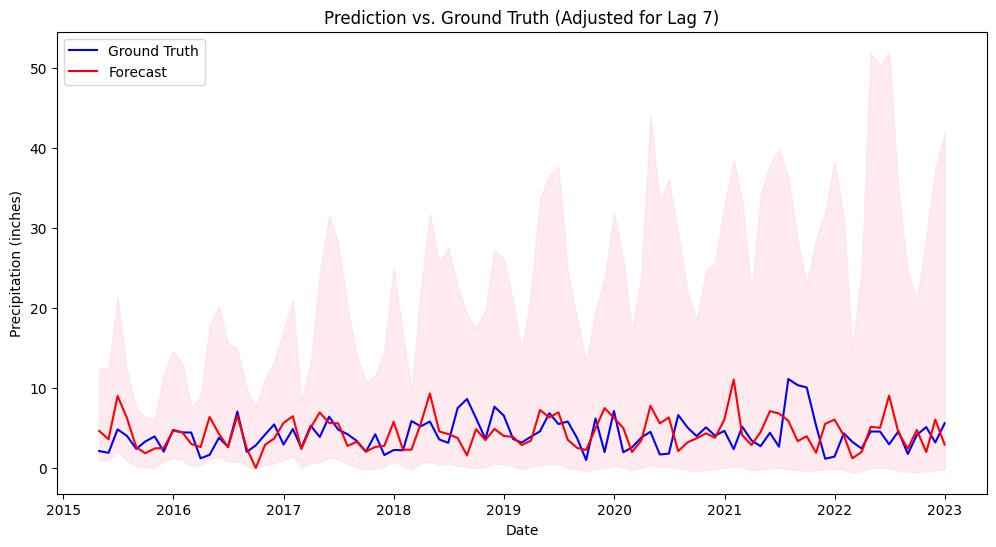

In [26]:
forecast_mean_exp = np.exp(hybrid_forecast) - 1
forecast_lower_exp = np.exp(forecast_ci.iloc[:, 0]) - 1
forecast_upper_exp = np.exp(forecast_ci.iloc[:, 1]) - 1
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_precip, label="Ground Truth", color="blue")
plt.plot(forecast_mean_exp, label="Forecast", color="red")
plt.fill_between(forecast_mean_exp.index, forecast_lower_exp, forecast_upper_exp, color='pink', alpha=0.3)
plt.title("Prediction vs. Ground Truth (Adjusted for Lag 7)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend()
plt.show()

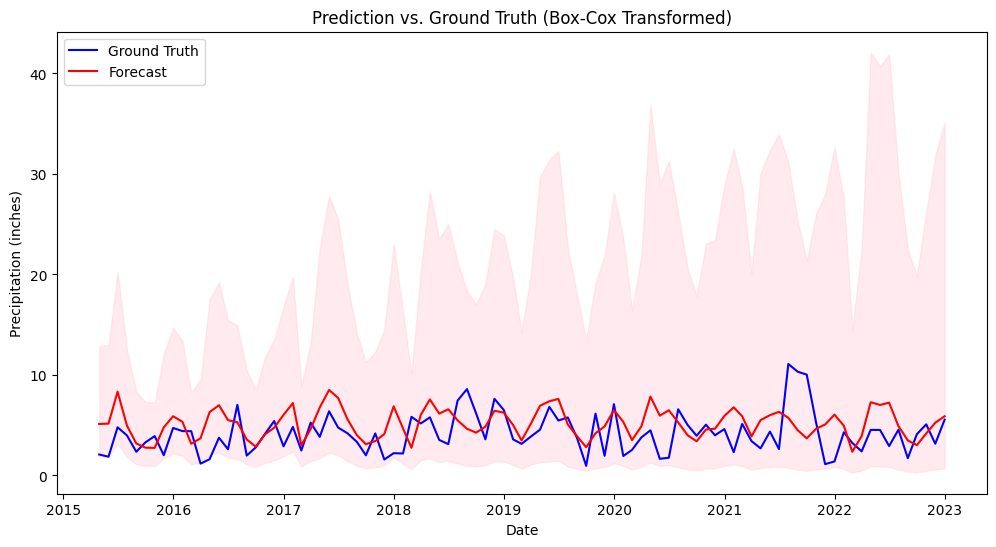

In [27]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Step 1: Apply Box-Cox transformation
train_precip_transformed, lambda_value = boxcox(train_precip + 1)  # Add 1 to avoid log(0)

# Step 2: Fit SARIMAX on transformed data
model = SARIMAX(train_precip_transformed, 
                exog=train_exog,  # Exogenous variables
                order=(2, 1, 1), 
                seasonal_order=(1, 1, 0, 12), 
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Step 3: Forecast on test set
forecast = results.get_forecast(steps=len(test_precip), exog=test_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 4: Back-transform predictions to original scale
forecast_mean_exp = inv_boxcox(forecast_mean, lambda_value)
forecast_lower = inv_boxcox(forecast_ci.iloc[:, 0], lambda_value)
forecast_upper = inv_boxcox(forecast_ci.iloc[:, 1], lambda_value)

# Step 5: Evaluate and plot results
plt.figure(figsize=(12, 6))
plt.plot(test_precip, label="Ground Truth", color="blue")
plt.plot(forecast_mean_exp, label="Forecast", color="red")
plt.fill_between(forecast_mean_exp.index, forecast_lower, forecast_upper, color='pink', alpha=0.3)
plt.title("Prediction vs. Ground Truth (Box-Cox Transformed)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend()
plt.show()